In [1]:
import os
import matplotlib.pyplot as plt
import shutil
import random
import albumentations as A
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Analysing the Distribution of the dataset to figure out which re-sampling technique to use.

In [2]:
DATASET_PATH = "data"
data_distribution = {}

In [3]:
for crop in os.listdir(DATASET_PATH):
    crop_path = os.path.join(DATASET_PATH, crop)
    
    if os.path.isdir(crop_path): 
        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            
            if os.path.isdir(disease_path):
                image_count = len(os.listdir(disease_path))
                data_distribution[f"{crop} - {disease}"] = image_count

data_distribution = dict(sorted(data_distribution.items(), key=lambda item: item[1], reverse=True))
for category, count in data_distribution.items():
    print(f"{category}: {count} images")

Rice_Leaf - Healthy: 1488 images
Rice_Leaf - LeafBlast: 779 images
Rice_Leaf - Hispa: 565 images
Rice_Leaf - BrownSpot: 523 images
Wheat_Leaf - Stripe_Rust: 208 images
Wheat_Leaf - Healthy: 102 images
Sugarcane_Leaf - Bacterial_Blight: 100 images
Sugarcane_Leaf - Healthy: 100 images
Sugarcane_Leaf - Red_Rot: 100 images
Wheat_Leaf - Septoria: 97 images


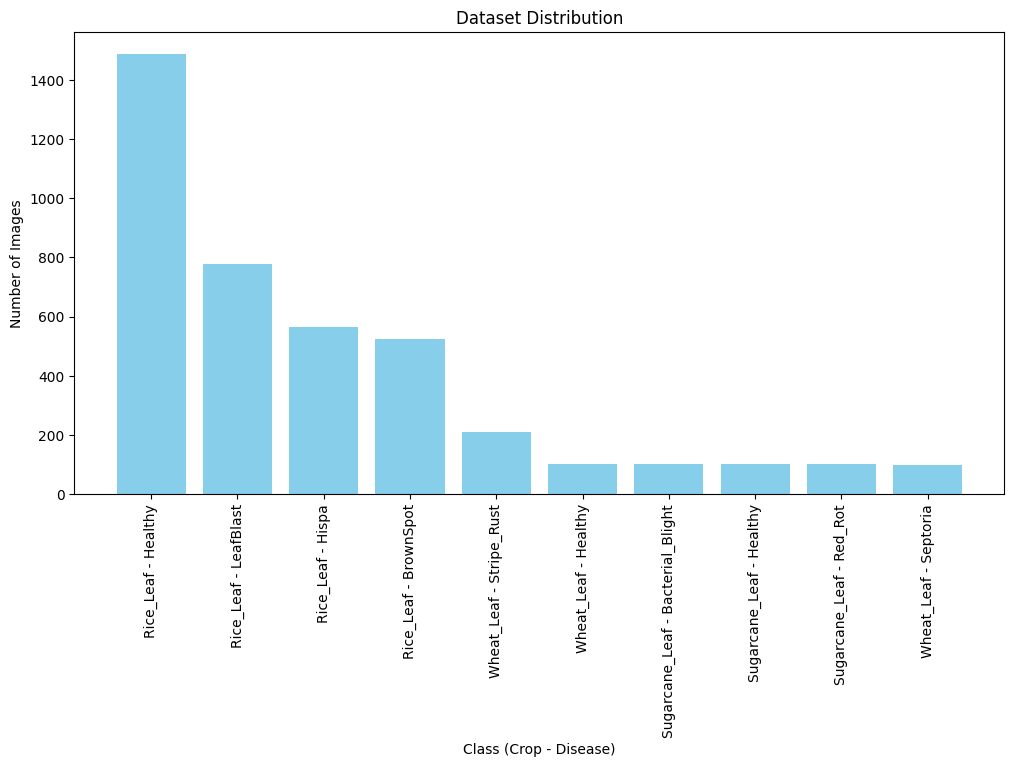

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(data_distribution.keys(), data_distribution.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Class (Crop - Disease)")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.show()

## Balance Datasets for accurate representation of each crop type and each disease

In [ ]:
DATASET_PATH = "data"
VALIDATION_PATH = "validation"

### Augment the data by flipping and Randomly Increase/Decrease Brightness and Contrast and Randomly Rotate the Images.

In [ ]:
# Augmentation function (for oversampling)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),
])

### Move the Images to validation folder if the train folder contains 500 Images.

In [ ]:
# Create validation folder
os.makedirs(VALIDATION_PATH, exist_ok=True)

def move_to_validation(class_path, class_name, crop_type, keep_count=500):
    """ Move excess images to validation set """
    val_class_path = os.path.join(VALIDATION_PATH, crop_type, class_name)
    os.makedirs(val_class_path, exist_ok=True)

    images = os.listdir(class_path)
    if len(images) > keep_count:
        to_move = images[keep_count:]
        for img in to_move:
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_path, img))

### Oversample the folders which contains <500 Images and then Augment them upto 600 by keeping 500 in train and 100 in validation set.

In [ ]:
def oversample(class_path, class_name, crop_type, target_count=600):
    """ Oversample minority classes using augmentation """
    images = os.listdir(class_path)
    if len(images) < target_count:
        os.makedirs(class_path, exist_ok=True)
        while len(os.listdir(class_path)) < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            augmented = augment(image=image)['image']
            new_img_name = f"aug_{random.randint(10000, 99999)}.jpg"
            cv2.imwrite(os.path.join(class_path, new_img_name), cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

In [ ]:
for crop in os.listdir(DATASET_PATH):
    crop_path = os.path.join(DATASET_PATH, crop)
    if os.path.isdir(crop_path):
        for disease in os.listdir(crop_path):
            class_path = os.path.join(crop_path, disease)

            if os.path.isdir(class_path):
                image_count = len(os.listdir(class_path))

                if crop == "Rice_Leaf":
                    move_to_validation(class_path, disease, crop, keep_count=500)
                
                else:
                    oversample(class_path, disease, crop, target_count=600)
                    move_to_validation(class_path, disease, crop, keep_count=500)



### Check the distribution of the Train set

Rice_Leaf - BrownSpot: 500 images
Rice_Leaf - Healthy: 500 images
Rice_Leaf - Hispa: 500 images
Rice_Leaf - LeafBlast: 500 images
Sugarcane_Leaf - Bacterial_Blight: 500 images
Sugarcane_Leaf - Healthy: 500 images
Sugarcane_Leaf - Red_Rot: 500 images
Wheat_Leaf - Healthy: 500 images
Wheat_Leaf - Septoria: 500 images
Wheat_Leaf - Stripe_Rust: 500 images


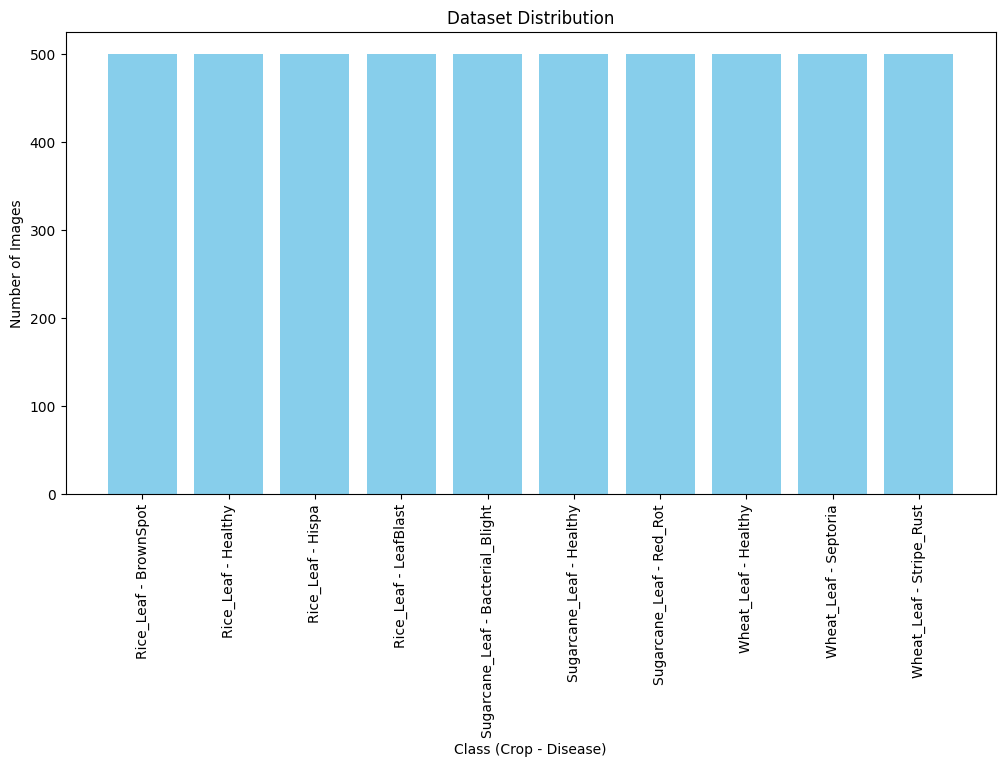

In [5]:
DATASET_PATH = "train"
data_distribution = {}
for crop in os.listdir(DATASET_PATH):
    crop_path = os.path.join(DATASET_PATH, crop)
    
    if os.path.isdir(crop_path): 
        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            
            if os.path.isdir(disease_path):
                image_count = len(os.listdir(disease_path))
                data_distribution[f"{crop} - {disease}"] = image_count

data_distribution = dict(sorted(data_distribution.items(), key=lambda item: item[1], reverse=True))
for category, count in data_distribution.items():
    print(f"{category}: {count} images")
plt.figure(figsize=(12, 6))
plt.bar(data_distribution.keys(), data_distribution.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Class (Crop - Disease)")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.show()

### Check the distribution of the validation set

Rice_Leaf - BrownSpot: 100 images
Rice_Leaf - Healthy: 100 images
Rice_Leaf - Hispa: 100 images
Rice_Leaf - LeafBlast: 100 images
Sugarcane_Leaf - Bacterial_Blight: 100 images
Sugarcane_Leaf - Healthy: 100 images
Sugarcane_Leaf - Red_Rot: 100 images
Wheat_Leaf - Healthy: 100 images
Wheat_Leaf - Septoria: 100 images
Wheat_Leaf - Stripe_Rust: 100 images


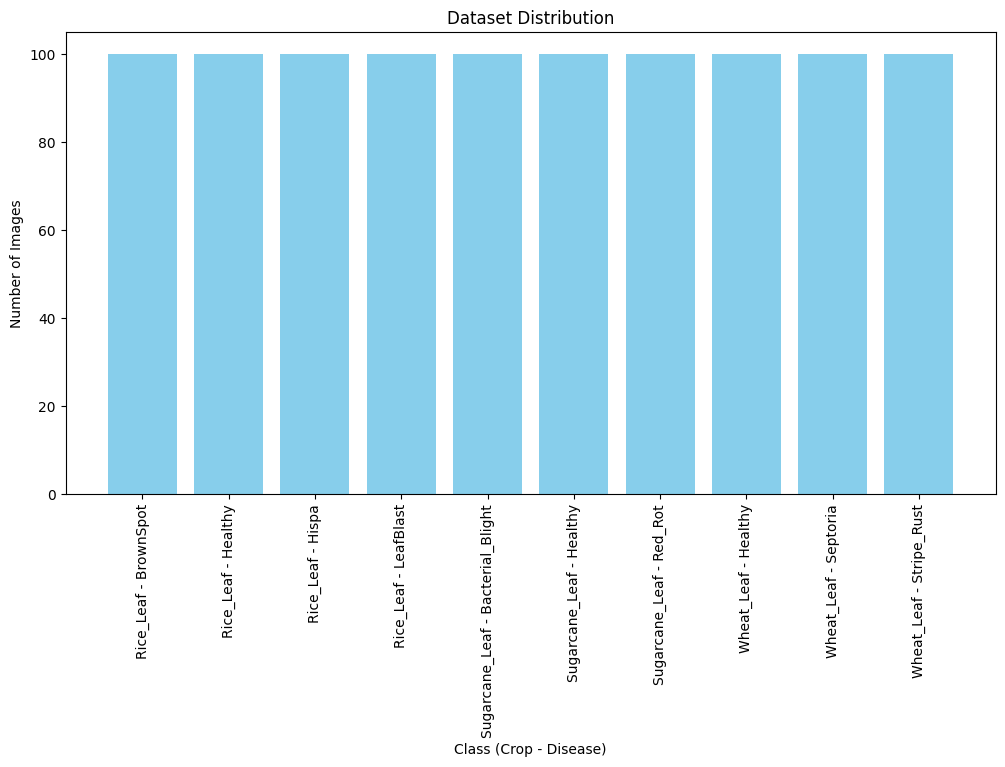

In [6]:
DATASET_PATH = "validation"
data_distribution = {}
for crop in os.listdir(DATASET_PATH):
    crop_path = os.path.join(DATASET_PATH, crop)
    
    if os.path.isdir(crop_path): 
        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            
            if os.path.isdir(disease_path):
                image_count = len(os.listdir(disease_path))
                data_distribution[f"{crop} - {disease}"] = image_count

data_distribution = dict(sorted(data_distribution.items(), key=lambda item: item[1], reverse=True))
for category, count in data_distribution.items():
    print(f"{category}: {count} images")
plt.figure(figsize=(12, 6))
plt.bar(data_distribution.keys(), data_distribution.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Class (Crop - Disease)")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.show()

### Modelling

In [7]:
IMG_SIZE = (224, 224, 3)

def build_crop_classifier():
    """Stage 1: Classifies crop type (Rice, Sugarcane, Wheat)"""
    
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
    base_model.trainable = True  # Fine-tune for better feature extraction

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')  # 3 classes (Rice, Sugarcane, Wheat)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


def build_disease_classifier():
    """Stage 2: Identifies disease based on crop type"""
    
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
    base_model.trainable = True  

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')  # 10 classes (9 diseases + Healthy)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
crop_model = build_crop_classifier()
print("Crop Classification Model Summary:")
crop_model.summary()

Crop Classification Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,248,019 (23.83 MB)

 Trainable params: 6,187,411 (23.60 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [9]:
disease_model = build_disease_classifier()
print("\nDisease Classification Model Summary:")
disease_model.summary()


Disease Classification Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,709,082 (25.59 MB)

 Trainable params: 6,648,474 (25.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

### Training

In [16]:
TRAIN_DIR = "train"
VAL_DIR = "validation"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

CROP_CLASSES = ["Rice_Leaf", "Sugarcane_Leaf", "Wheat_Leaf"]
DISEASE_CLASSES = [
    "Rice_BrownSpot", "Rice_Healthy", "Rice_Hispa", "Rice_LeafBlast",
    "Sugarcane_Bacterial_Blight", "Sugarcane_Healthy", "Sugarcane_RedRot",
    "Wheat_Healthy", "Wheat_Septoria", "Wheat_Stripe_Rust"
]

### Load Data for Stage 1

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_crop_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse", 
    classes=CROP_CLASSES
)

val_crop_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    classes=CROP_CLASSES
)

Found 5000 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.


### Stage 1 Training

In [18]:
# Train Stage 1: Crop Classification
crop_model = build_crop_classifier()

crop_model.fit(
    train_crop_gen,
    validation_data=val_crop_gen,
    epochs=20,  # Adjust based on performance
    batch_size=BATCH_SIZE
)

# Save Stage 1 model
crop_model.save("crop_classifier.h5")



ValueError: `input_shape` must be a tuple of three integers.

### Stage 2: Disease Classification Training

In [ ]:
# Helper function to relabel images based on crop type
def generate_disease_data():
    """Creates a generator that assigns disease labels using the predicted crop class."""
    for images, crop_labels in train_crop_gen:
        crop_names = [CROP_CLASSES[int(lbl)] for lbl in crop_labels]
        disease_labels = []
        for i, crop in enumerate(crop_names):
            for j, disease in enumerate(DISEASE_CLASSES):
                if disease.startswith(crop):
                    disease_labels.append(j)
        yield images, tf.convert_to_tensor(disease_labels, dtype=tf.int32)

# Load Stage 2 Dataset (Disease Classification)
train_disease_gen = generate_disease_data()
val_disease_gen = generate_disease_data()

# Train Stage 2: Disease Classification
disease_model = build_disease_classifier()

disease_model.fit(
    train_disease_gen,
    validation_data=val_disease_gen,
    epochs=25,  # Adjust based on performance
    batch_size=BATCH_SIZE
)

# Save Stage 2 model
disease_model.save("disease_classifier.h5")

print("Training complete! Models saved.")